# Obtain a representation for the null latent

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from ava.data.data_container import DataContainer
from ava.plotting.grid_plot import indexed_grid_plot_DC
import audio_utils.io
from itertools import repeat
from joblib import Parallel, delayed
from ava.preprocessing.utils import get_spec
from ava.models.vae import X_SHAPE, VAE
from ava.preprocessing.preprocess import process_sylls
import torch

/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/vafeidis/.conda/envs/behavior/lib/python3.11/site-packages/uma

In [3]:
%matplotlib inline

## Ava project path

In [4]:
root = '/mnt/labNAS/usv_calls/usv_note_analysis/03_div_cage_group01_18_song_empty'
audio_dirs = [os.path.join(root, 'audio')]
seg_dirs = [os.path.join(root, 'segs_null')]
proj_dirs = [os.path.join(root, 'projections_null')]
spec_dirs = [os.path.join(root, 'specs_null')]
model_filename = os.path.join(root, 'checkpoint_200.tar')
plots_dir = root
dc = DataContainer(projection_dirs=proj_dirs, spec_dirs=spec_dirs, plots_dir=plots_dir, model_filename=model_filename)

## Preprocessing

In [5]:
params = {
    'preprocess': {
        'get_spec': get_spec,
        'max_dur': 0.2, # maximum syllable duration
        'min_freq': 10e3, # minimum frequency
        'max_freq': 100e3, # maximum frequency
        'num_freq_bins': X_SHAPE[0], # hard-coded
        'num_time_bins': X_SHAPE[1], # hard-coded
        'nperseg': 1024, # FFT
        'noverlap': 512, # FFT
        'spec_min_val': 1.5, # minimum log-spectrogram value
        'spec_noise_thres': 2.5, # if no value in spectogram is above this, co
        'spec_max_val': 4.5, # maximum log-spectrogram value
        'fs': 250000, # audio samplerate
        'mel': False, # frequency spacing, mel or linear
        'time_stretch': False, # stretch short syllables?
        'within_syll_normalize': True, # normalize spectrogram values on a
                                        # spectrogram-by-spectrogram basis
        'normalize_quantile': 0.0, # throw away values below this quantile
        'max_num_syllables': None, # maximum number of syllables per directory
        'sylls_per_file': 1, # syllable per file
        'sigma': 1,
        'flip': False,
        'notch_filter': False, # whether to apply notch filter for 60 kHz noise
        'fn': 54e3, # frequency of notch filter
        'q': 30, # quality factor
        'real_preprocess_params': ('min_freq', 'max_freq', 'spec_min_val', \
                'spec_max_val', 'max_dur'), # tunable parameters
        'int_preprocess_params': ('nperseg','noverlap'), # tunable parameters
        'binary_preprocess_params': ('time_stretch', 'mel', \
                'within_syll_normalize'), # tunable parameters
    },
}

In [6]:
n_jobs = os.cpu_count()-1
gen = zip(audio_dirs, seg_dirs, spec_dirs, repeat(params['preprocess']))
Parallel(n_jobs=n_jobs)(delayed(process_sylls)(*args) for args in gen)

[None]

## Embed latent means

In [7]:
latent_means = dc.request('latent_means')

Making field: latent_means
Making field: latent_means
	Done with: latent_means


## Obtain average null latent and visualize

In [8]:
# Define model
model = VAE(save_dir=root)
model.load_state(model_filename)

In [9]:
# Get average null latent spectogram
null_latent = torch.from_numpy(np.average(latent_means,axis=0)).to('cuda').to(torch.float32)
null_latent_spec = model.decode(null_latent).cpu().detach().numpy().reshape((X_SHAPE[0],X_SHAPE[1]))

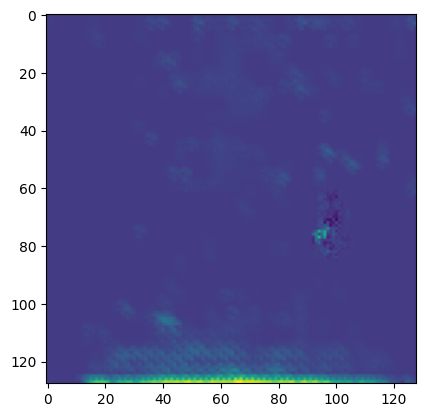

In [10]:
plt.imshow(np.flipud(null_latent_spec))

In [11]:
# Get spectograms from components
latent_means = torch.from_numpy(latent_means).to('cuda').to(torch.float32)
latent_means_spec = model.decode(latent_means).cpu().detach().numpy().reshape((-1,X_SHAPE[0],X_SHAPE[1]))

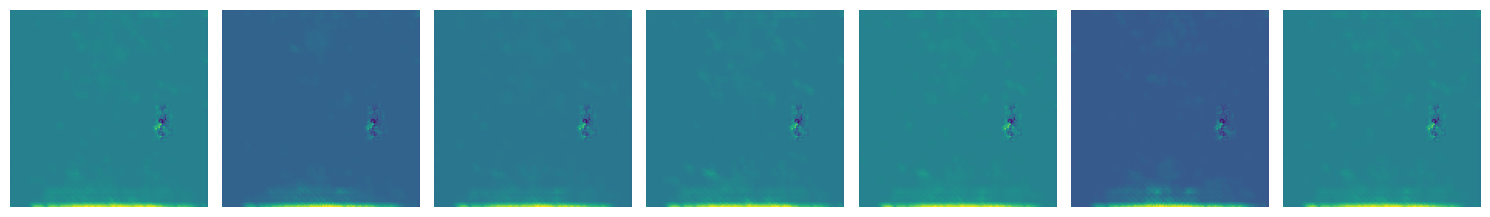

In [64]:
# Plot reconstructions

n_plot = 7
np.random.seed(53)
to_plot = np.random.choice(latent_means_spec.shape[0], size=n_plot, replace=False)

# Set up the subplots grid
fig, axes = plt.subplots(1, n_plot, figsize=(15, 3))

# Iterate over the images and plot them
for i in range(n_plot):
    # Plot the image in the corresponding subplot
    axes[i].imshow(np.flipud(latent_means_spec[to_plot[i]]))
    axes[i].axis('off')  # Turn off the axis labels
    
# Set a common scale for all images
for ax in axes:
    ax.set_aspect('equal')  # Set equal aspect ratio for all subplots
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [65]:
num = 5
to_plot[num]

32

In [66]:
latent_means[to_plot[num]]

tensor([ 1.6440e-01,  5.9183e-03, -2.7594e-02,  5.0176e-02, -4.6035e-01,
        -3.1524e-03, -5.1070e-02,  4.1769e-02, -7.0729e-01,  4.0119e-02,
        -6.2275e-03,  7.8491e-02,  6.1226e-01, -8.3325e-04, -1.0834e-02,
         3.4479e-04, -1.8880e-02,  8.3764e-03, -3.6340e-02,  3.0098e-02,
        -1.0854e+00, -5.1643e-03, -1.8238e-01,  2.0656e-02, -9.1891e-03,
         5.3880e-01,  2.4877e-02,  2.2066e-02,  3.4124e-03,  9.6549e-02,
        -1.3875e-02, -3.2071e-02], device='cuda:0')

In [67]:
np.save('empty_latent.npy',latent_means[to_plot[num]].cpu().detach().numpy())

## What about zero latent?

In [13]:
zero_spec = model.decode(torch.zeros((1,32)).to('cuda').to(torch.float32)).cpu().detach().numpy().reshape((X_SHAPE[0],X_SHAPE[1]))

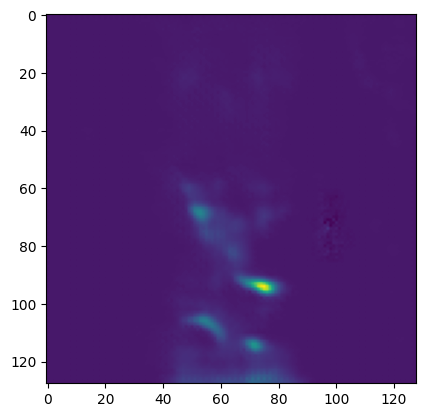

In [14]:
plt.imshow(np.flipud(zero_spec))